In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
import pysindy as ps
import torch
import torch.nn as nn

import sys
sys.path.append("../")
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"


from HyperSINDy import Net
from baseline import Trainer
from library_utils import Library
from Datasets import SyntheticDataset
from other import init_weights, make_folder, set_random_seed
from exp_utils import get_equations, log_equations


sns.set()

In [2]:
def load_model(device, z_dim, poly_order, include_constant,
               noise_dim, hidden_dim, stat_size, batch_size,
               cp_path):

    torch.cuda.set_device(device=device)
    device = torch.cuda.current_device()

    library = Library(n=z_dim, poly_order=poly_order, include_constant=include_constant)

    net = Net(library, noise_dim=noise_dim, hidden_dim=hidden_dim,
              statistic_batch_size=stat_size, num_hidden=num_hidden).to(device)
    net.get_masked_coefficients(batch_size=batch_size, device=device)

    cp = torch.load(cp_path, map_location="cuda:" + str(device)) 
    net.load_state_dict(cp['model'])
    net.to(device)
    net = net.eval()
    
    return net, library, device

#https://github.com/urban-fasel/EnsembleSINDy
def fourth_order_diff(x, dt):
    dx = np.zeros([x.shape[0], x.shape[1]])
    dx[0] = (-11.0 / 6) * x[0] + 3 * x[1] - 1.5 * x[2] + x[3] / 3
    dx[1] = (-11.0 / 6) * x[1] + 3 * x[2] - 1.5 * x[3] + x[4] / 3
    dx[2:-2] = (-1.0 / 12) * x[4:] + (2.0 / 3) * x[3:-1] - (2.0 / 3) * x[1:-3] + (1.0 / 12) * x[:-4]
    dx[-2] = (11.0 / 6) * x[-2] - 3.0 * x[-3] + 1.5 * x[-4] - x[-5] / 3.0
    dx[-1] = (11.0 / 6) * x[-1] - 3.0 * x[-2] + 1.5 * x[-3] - x[-4] / 3.0
    return dx / dt 

def fit_esindy(x_train, x_dot, degree, include_bias, threshold, thresholder, max_iter, n_models):
    set_random_seed(SEED)
    feature_names = ['x', 'y', 'z']
    ps_library = ps.PolynomialLibrary(degree=degree, include_bias=include_bias)
    optimizer = ps.SR3(
        threshold=threshold, thresholder=thresholder, max_iter=max_iter, tol=1e-1
    )
    model = ps.SINDy(feature_names=feature_names, feature_library=ps_library, optimizer=optimizer)
    model.fit(x_train, x_dot=x_dot, t=dt, ensemble=True, quiet=True, n_models=n_models)
    return model

In [3]:
SEED = 5281998
set_random_seed(SEED)

In [4]:
device = 2
noise_dim = 4
batch_size = 250

data_folder = "../data/"
model = "HyperSINDy"
dt = 0.005
hidden_dim = 64
stat_size = 250
num_hidden = 5
z_dim = 2
adam_reg = 1e-2
gamma_factor = 0.999
poly_order = 3
include_constant = True
runs = "runs/"
library = Library(n=z_dim, poly_order=poly_order, include_constant=include_constant)
t = None

In [5]:
cp_path = "../runs/lotkavolterra/cp_1.pt"
params = np.load(data_folder + "lotkavolterra/scale-5.0/x_params.npy")

In [6]:
net, library, device = load_model(device, z_dim, poly_order, include_constant,
                                  noise_dim, hidden_dim, stat_size, batch_size,
                                  cp_path)

In [7]:
x_train = np.load('../data/lotkavolterra/scale-5.0/x_train.npy')
x_dot = fourth_order_diff(x_train, dt)

In [8]:
esindy = fit_esindy(x_train, x_dot, 2, True, 2.5, "l0", 2000, 1000)
ensemble_coefs = np.array(esindy.coef_list)
esindy.print()

(x)' = 6.337 x + -5.366 x y
(y)' = -2.614 1 + -3.753 y + 6.465 x y


In [9]:
ensemble_coefs = np.transpose(ensemble_coefs, (0, 2, 1))

In [10]:
ensemble_coefs.mean(0)

array([[-0.51041976,  2.11935125],
       [ 4.13065268, -0.82662148],
       [ 1.94627072, -8.64534677],
       [ 0.        ,  0.        ],
       [-5.44831159,  6.41615572],
       [ 0.        ,  0.        ]])

In [11]:
e1 = ensemble_coefs[:,1,0]
e2 = ensemble_coefs[:,4,0]
e3 = ensemble_coefs[:,2,1]
e4 = ensemble_coefs[:,4,1]
es = [e1, e2, e3, e4]
terms = ['x', 'xy', 'y', 'xy']

In [12]:
coefs = net.get_masked_coefficients(batch_size=1000, device=device)
#coefs = net.get_masked_coefficients(batch_size=10000, device=device)
c1 = coefs[:,1,0]
c2 = coefs[:,4,0]
c3 = coefs[:,2,1]
c4 = coefs[:,4,1]
cs = [c1, c2, c3, c4]
cs = [c.detach().cpu().numpy() for c in cs]
terms = ['x', 'xy', 'y', 'xy']

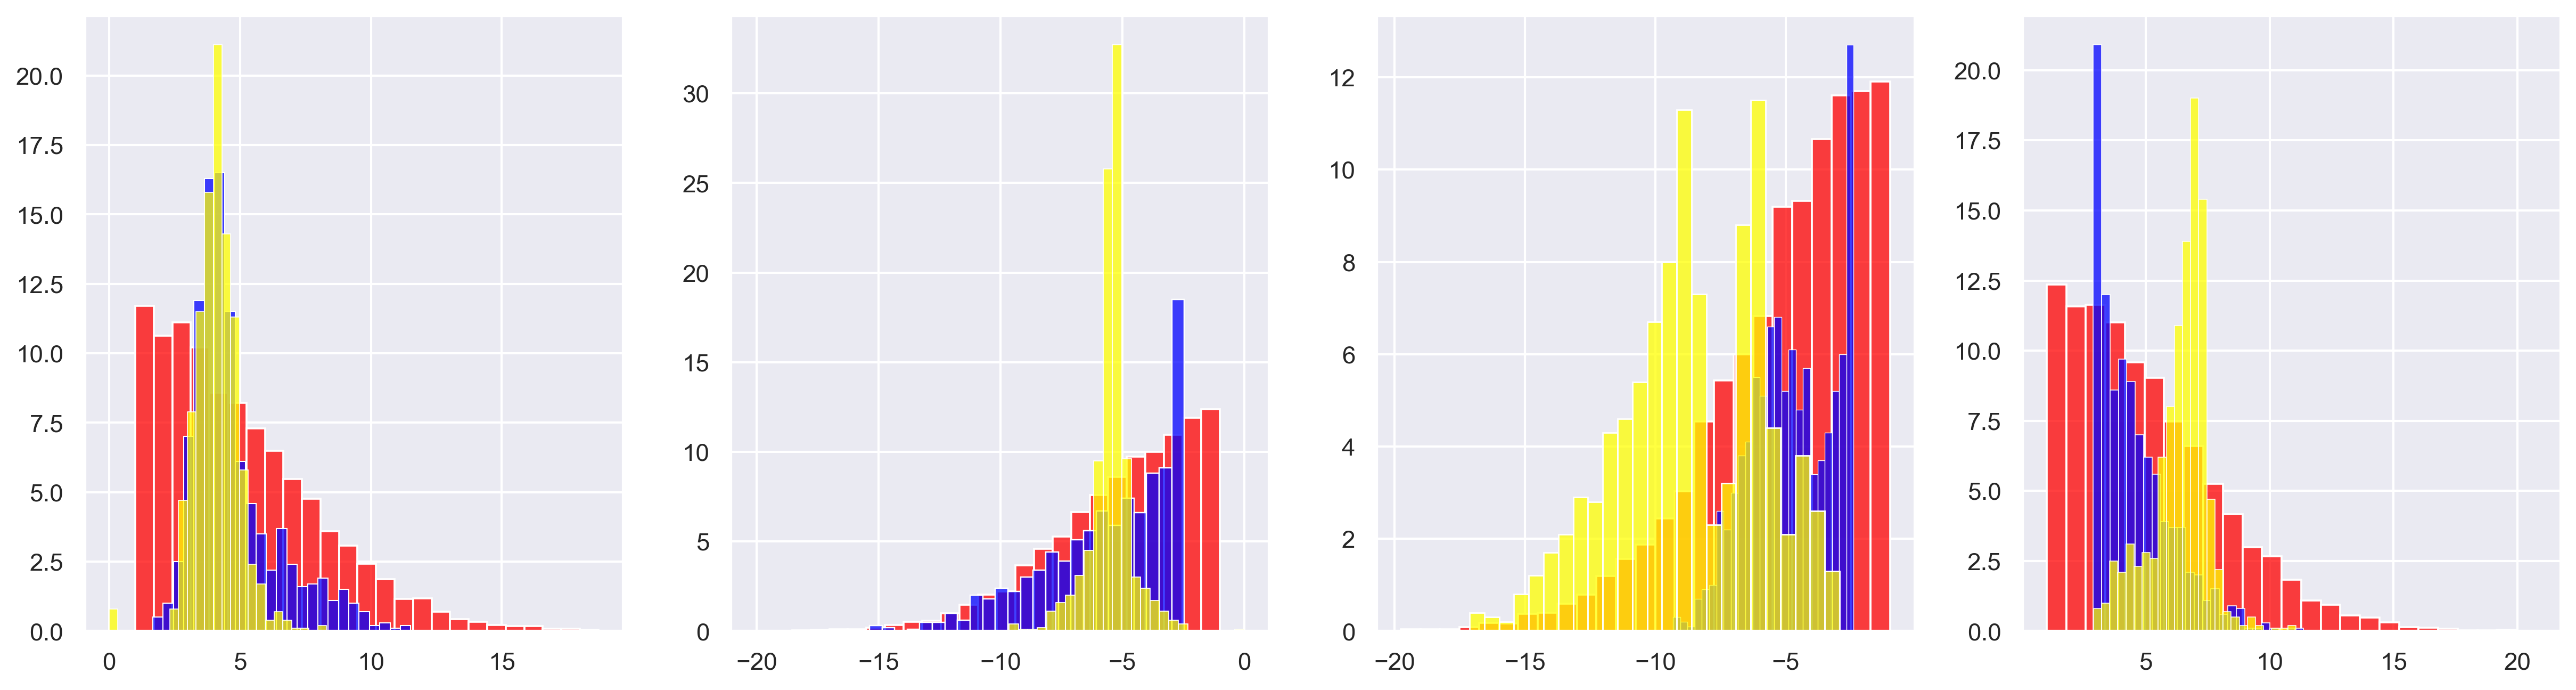

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), dpi=300)
for i in range(4):    
    true_coefs = params[:,i]
    if i == 1 or i == 2:
        true_coefs = params[:,i] * -1
    sns.histplot(true_coefs, ax=axes[i], stat='percent', color='red', bins=25)
    sns.histplot(cs[i], ax=axes[i], stat='percent', color='blue', bins=25)
    sns.histplot(es[i], ax=axes[i], stat='percent', color='yellow', bins=25)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
plt.savefig("../results/fig3.png")
plt.show()